In [1]:
import numpy as np
import pandas as pd
import warnings
import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from cyvcf2 import VCF
from collections import defaultdict

In [2]:
def bubble_df_maker(bubble_data,limit,step,tool_1,tool_2):
    keys = []
    for i in range(-limit,limit,step):
        for j in range(-limit,limit,step):
            keys.append((i,j))
    bubble_intervals = {k:0 for k in keys}

    upper_limits = 0
    for index,row in bubble_data.iterrows():
        if abs(row[tool_1]) >= limit or abs(row[tool_2]) >= limit:
            upper_limits += 1
            continue
        x = math.floor(row[tool_1] / step ) * step
        y = math.floor(row[tool_2] / step ) * step
        bubble_intervals[(x,y)] += 1
    bubble_df = pd.DataFrame(bubble_intervals.items(), columns=['Interval', 'size'])
    bubble_df['Interval'] = bubble_df['Interval'].astype(str).str.replace("(","")
    bubble_df['Interval'] = bubble_df['Interval'].str.replace(")","")
    bubble_df[['x','y']] = bubble_df['Interval'].str.split(",",expand = True)
    return bubble_df

In [3]:
def bubble_plot(bubble_df, limit, step, legend_values,period,tool_name_1,tool_name_2):
    dis = 4
    scale = 1000/np.mean(list(bubble_df['size']))

    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.scatter(bubble_df['x'], bubble_df['y'],
                           s=np.sqrt(bubble_df['size']*scale),
                           color="darkblue",
                           alpha=0.5)
    ax.set_xlabel(tool_name_1, size=18)
    ax.set_ylabel(tool_name_2, size=18)
    ax.plot([0, 2*limit/step - 1], [0, 2*limit/step - 1], linestyle="dashed", color="gray", alpha=0.75)  
    ax.set_xticks(ax.get_xticks()[::dis])
    ax.set_yticks(ax.get_yticks()[::dis])
    ax.set_xticklabels(np.arange(-limit, limit, dis*step))
    ax.set_yticklabels(np.arange(-limit, limit, dis*step))
    ax.annotate("#TRs", xy=(0.5,2*limit/step - 3))
    for i, val in enumerate(legend_values):
        xval = 0.5
        yval = 2*limit/step - 5 - 3*i
        ax.scatter([xval], [yval], color="darkblue", s=np.sqrt(val*scale))
        ax.annotate(val, xy=(xval+1+0.2*i,yval-0.5))
    plt.savefig("pdfs/SR_LR_bubble.pdf", dpi=700)
    plt.show()
    

In [4]:
def to_int(val):
    if math.isnan(val):
        return np.nan
    else:
        return(int(val))

In [13]:
######## Reading HipSTR and HipSTR-long records on long reads #######
n = 1638945 #length of GRCh38.hipstr_reference_pre.bed
HipSTR_long_records = []

for chrom in [i for i in range(1,23)] + ['X', 'Y']:
    addr = f'/expanse/projects/gymreklab/helia/HipSTR_LR/tests/whole_genome/output/HG002_wg_HiFi_HipSTR_long_chr{chrom}.vcf.gz'
    hipstr_LR = VCF(addr)
    for record in hipstr_LR:
        alleles = record.INFO['INEXACT_ALLELE']
        alt_alleles = 0
        inexact_alleles = 0
        if alleles != None:
            if type(alleles) == int:
                alt_alleles += 1
                inexact_alleles += alleles
            if type(alleles) == tuple:
                alt_alleles += len(alleles)
                inexact_alleles += sum(alleles)              
        HipSTR_long_records.append([record.CHROM, record.POS, record.REF, record.INFO['PERIOD'],
                                record.INFO['END'], record.ID, record.gt_bases[0], record.format('ALLREADS')[0],
                                alt_alleles, inexact_alleles])
        
HipSTR_long_df = pd.DataFrame(HipSTR_long_records, columns = ['#CHROM',"START", 
                                                              "REF", "PERIOD", "END", "ID","GT", "ALLREADS",
                                                              "alt_alleles", 'inexact_alleles'])


HipSTR_short_records = []
addr = f'/expanse/projects/gymreklab/helia/HipSTR_LR/tests/whole_genome/output/HG002_wg_Illumina_HipSTR_short.vcf.gz'
hipstr_SR = VCF(addr)
for record in hipstr_SR:
    HipSTR_short_records.append([record.CHROM, record.POS, record.REF, record.INFO['PERIOD'],
                                record.INFO['END'], record.format("GB")[0], record.ID, record.gt_bases[0], record.format('ALLREADS')[0]])
        
HipSTR_short_df = pd.DataFrame(HipSTR_short_records, columns = ['#CHROM',"START", "REF", 
                                                                "PERIOD", "END", "GB", "ID","GT", "ALLREADS"])

# HipSTR_short_records_HiFi = []
# for chrom in [i for i in range(1,23)] + ['X', 'Y']:
#     addr = f'/expanse/projects/gymreklab/helia/HipSTR_LR/tests/whole_genome/output/HG002_wg_HiFi_HipSTR_short_chr{chrom}.vcf.gz'
#     hipstr_SR_HiFi = VCF(addr)
#     for record in hipstr_SR_HiFi:
#         HipSTR_short_records_HiFi.append([record.CHROM, record.POS, record.REF, record.INFO['PERIOD'],
#                                 record.INFO['END'], record.ID, record.gt_bases[0], record.format('ALLREADS')[0], record.format("FILTER")[0]])
        
# HipSTR_short_HiFi_df = pd.DataFrame(HipSTR_short_records_HiFi,
#                                     columns = ['#CHROM',"START", "REF", "PERIOD", 
#                                                "END", "ID","GT", "ALLREADS", "FILTER"])


In [27]:
######## Merging ########

def dif_mean_len(CHROM, REF_long, GT_long, REF_short, GT_short):
    if CHROM in ['chrY', 'chrX']:
        return len(GT_long) - len(REF_long), len(GT_short) - len(REF_short)
    GT_long = GT_long.split("|")
    GT_short = GT_short.split("|")
    assert(len(GT_long) == 2 and len(GT_short) == 2) # Both have calls
    
    GB_long = sorted([len(x) - len(REF_long) for x in GT_long])
    GB_short = sorted([len(x) - len(REF_short) for x in GT_short])
    
    return np.mean(GB_long), np.mean(GB_short)

def diff_GT(GT, PERIOD):
    GT = GT.split("|")
    assert(len(GT) == 2)
    return int(abs(len(GT[0]) - len(GT[1])) / PERIOD)
    
    
    
both = HipSTR_short_df.merge(HipSTR_long_df, on = ['#CHROM', 'ID', 'PERIOD'], 
                             how = 'outer', suffixes = ['_short', '_long'])


both['LEN_long'] = both['END_long'] - both['START_long']
both['LEN_short'] = both['END_short'] - both['START_short']

assert(not both['ID'].duplicated().any()) # No duplicate ID

n_long_calls = len(both[(~both['GT_long'].isna()) & (both['GT_long'].str.len() > 1)])
n_short_calls = len(both[(~both['GT_short'].isna()) & (both['GT_short'].str.len() > 1)])
print(f"% of calls genotyped by HipSTR: {n_short_calls/n}") 
print(f"% of calls genotyped by HipSTR-long: {n_long_calls/n}")

both_with_calls = both[(~both['GT_long'].isna()) & (both['GT_long'].str.len() > 1) &
                       (~both['GT_short'].isna()) & (both['GT_short'].str.len() > 1)]

both_with_calls[['HipSTR_long_mean', 'HipSTR_mean']] = both_with_calls.apply(lambda row: dif_mean_len(row['#CHROM'],
                                                                                                      row['REF_long'], 
                                                                                 row['GT_long'], row['REF_short'], 
                                                                                 row['GT_short']), axis = 1,
                                                                                 result_type='expand')

both_with_calls['diff_GT_long'] = both_with_calls[~both_with_calls['#CHROM'].isin(['chrY', 
                                                                                  'chrX'])].apply(lambda row: diff_GT(row['GT_long'], row['PERIOD']), 
                                                        axis = 1)



% of calls genotyped by HipSTR: 0.9504919323101141
% of calls genotyped by HipSTR-long: 0.9951474881707439


KeyboardInterrupt: 

In [7]:
###### Analyze filter reasons by HipSTR ######

low_coverage=!grep "Skipping locus with too few reads" log/HipSTR_SR.e33789941 | wc -l
len_above_100=!grep "Skipping region as the reference allele length exceeds" log/HipSTR_SR.e33789941 | wc -l
assembly_cycle=!grep "FLANK_ASSEMBLY_CYCLIC" log/HipSTR_SR.e33789941 | wc -l
flank_indel=!grep "FLANK_INDEL_FRAC" log/HipSTR_SR.e33789941 | wc -l
flank_indel_ass=!grep "FLANK_ASSEMBLY_INDEL" log/HipSTR_SR.e33789941 | wc -l
repetitive_region=!grep "repeat is too repetitive for accurate genotyping" log/HipSTR_SR.e33789941 | wc -l


print(f'low coverage: {round(int(low_coverage[0])/n * 100,2)}')
print(f'above_100: {round(int(len_above_100[0])/n * 100,2)}')
print(f'assembly cyclic: {round(int(assembly_cycle[0])/n * 100,2)}')
print(f'flank_indel: {round(int(flank_indel[0])/n * 100,2)}')
print(f'flank_indel_ass: {round(int(flank_indel_ass[0])/n * 100,2)}')
print(f'repetitive: {round(int(repetitive_region[0])/n * 100,2)}')

low coverage: 1.22
above_100: 0.0
assembly cyclic: 2.14
flank_indel: 0.0
flank_indel_ass: 0.72
repetitive: 0.71


In [42]:
def concordance(CHROM, diff, REF_long, GT_long, REF_short, GT_short):
    if CHROM in ['chrY', 'chrX']:
        GB_long = len(GT_long) - len(REF_long)
        GB_short = len(GT_short) - len(REF_short)
        if abs(GB_long - GB_short) < 2:
            return 1
        return 0
    GT_long = GT_long.split("|")
    GT_short = GT_short.split("|")
    assert(len(GT_long) == 2 and len(GT_short) == 2) # Both have calls
    
    GB_long = sorted([len(x) - len(REF_long) for x in GT_long])
    GB_short = sorted([len(x) - len(REF_short) for x in GT_short]) 
    
    if abs(GB_long[0] - GB_short[0]) < diff and abs(GB_long[1] - GB_short[1]) < diff:
        return 1
    return 0

both_with_calls['concordance'] = both_with_calls.apply(lambda row: concordance(row['#CHROM'],1, row['REF_long'], 
                                                                                 row['GT_long'], row['REF_short'], 
                                                                                 row['GT_short']), axis = 1)

both_with_calls['concordance_1'] = both_with_calls.apply(lambda row: concordance(row['#CHROM'],2, row['REF_long'], 
                                                                                 row['GT_long'], row['REF_short'], 
                                                                                 row['GT_short']), axis = 1)
print(f"total concordance: {len(both_with_calls[both_with_calls['concordance_1'] == 1]) / len(both_with_calls)}, {len(both_with_calls)}")
for i in range(1,7):
    pdata = both_with_calls[both_with_calls['PERIOD'] == i]
    print(i, np.mean(pdata['concordance_1']))

# print(f"% of discordance happening in homopolymers: {len(both_with_calls[(both_with_calls['concordance'] == 0) & (both_with_calls['PERIOD'] == 1)])/len(both_with_calls[both_with_calls['concordance'] == 0])}")
                                                                                                                                
# homopolymer_discordant = both_with_calls[(both_with_calls['concordance'] == 0) & (both_with_calls['PERIOD'] == 1)]

# print(len(homopolymer_discordant[homopolymer_discordant['concordance_1'] == 1])/ len(homopolymer_discordant))
                                                                                                                                

total concordance: 0.9671620366027149, 1556278
1 0.9572988456210174
2 0.9661704523115964
3 0.9883838837618247
4 0.9831264495617654
5 0.9827992943300238
6 0.9859233033314849


In [46]:
print(f"total concordance: {len(both_with_calls[both_with_calls['concordance'] == 1]) / len(both_with_calls)}, {len(both_with_calls)}")


total concordance: 0.8762849568007772, 1556278


0.14107749555088173
0.0059238603755962325
total concordance: 0.8762849568007772, 1556278
total concordance: 0.25872323552735926, 5044


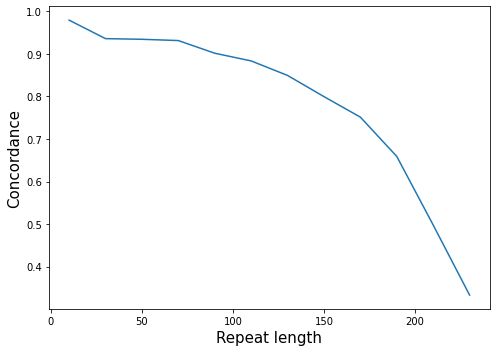

In [45]:
longer_than_100 = both_with_calls[both_with_calls['LEN_short'] > 250]
print(np.sum(longer_than_100['inexact_alleles'])/np.sum(longer_than_100['alt_alleles']))
print(np.sum(both_with_calls['inexact_alleles'])/np.sum(both_with_calls['alt_alleles']))
print(f"total concordance: {len(both_with_calls[both_with_calls['concordance'] == 1]) / len(both_with_calls)}, {len(both_with_calls)}")

print(f"total concordance: {len(longer_than_100[longer_than_100['concordance_1'] == 1]) / len(longer_than_100)}, {len(longer_than_100)}")
MINLEN = 10
MAXLEN = 250


fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)


lenbins = range(MINLEN, MAXLEN+1,20)
xvals = []
yvals = []
for j in range(len(lenbins)-1):
    lb = lenbins[j]
    ub = lenbins[j+1]
    xx = both_with_calls[(both_with_calls['LEN_short']>=lb) & (both_with_calls['LEN_short']<ub)]

    if len(xx) > 10:
        xvals.append(lb)
        yvals.append(len(xx[xx['concordance_1']  == 1])/len(xx))
ax.plot(xvals, yvals)
ax.set_xlabel("Repeat length", size=15)
ax.set_ylabel("Concordance", size=15)
fig.tight_layout()

plt.savefig("pdfs/concordance_vs_length.pdf", dpi=1200)

In [64]:

# bins = np.linspace(0,1000,100)
# plt.figure(figsize = (10,7))
# plt.hist([both['LEN_long'], both['LEN_short']], bins, label=['HipSTR-long', 'HipSTR'])
# #plt.legend(loc='upper right')
# plt.yscale('log')
# plt.xlabel("Total length of STR",fontsize=18)
# plt.ylabel("Number of genotyped STRs",fontsize=18)
# plt.savefig("pdfs/number_of_genotypes.jpg", dpi=700)
# plt.show()


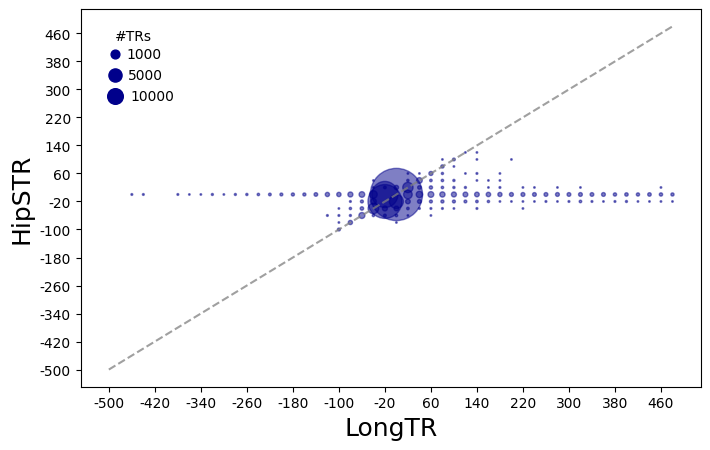

In [49]:
bubble_df = bubble_df_maker(both_with_calls, 500, 20,'HipSTR_long_mean', 'HipSTR_mean')
bubble_plot(bubble_df,500,20,[1000,5000,10000],"", "LongTR", "HipSTR")

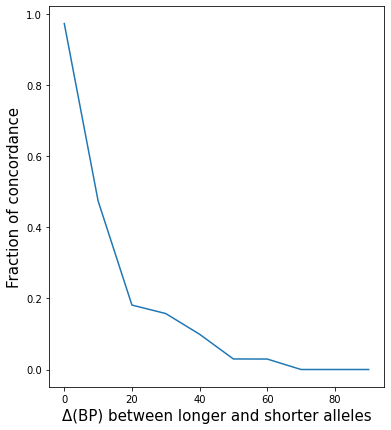

In [62]:
MINLEN = 0
MAXLEN = 100


fig = plt.figure()
fig.set_size_inches((6, 7))
ax = fig.add_subplot(111)


lenbins = range(MINLEN, MAXLEN+1,10)
xvals = []
yvals = []
for j in range(len(lenbins)-1):
    lb = lenbins[j]
    ub = lenbins[j+1]
    xx = both_with_calls[(both_with_calls['diff_GT_long']>=lb) & (both_with_calls['diff_GT_long']<ub)]

    if len(xx) > 10:
        xvals.append(lb)
        yvals.append(len(xx[xx['concordance_1'] == 1])/len(xx))
ax.plot(xvals, yvals)
plt.xlabel("\u0394(BP) between longer and shorter alleles",fontsize=15)
plt.ylabel("Fraction of concordance",fontsize=15)
# display(long_allele_dropout)
# long_allele_dropout['concordance_perc'] = long_allele_dropout['concordance_1'] / long_allele_dropout['LEN_long'] 
# long_allele_dropout = long_allele_dropout[long_allele_dropout['diff_GT_long'] < 1000] 
# long_allele_dropout = long_allele_dropout[long_allele_dropout['diff_GT_long'] > 10]
# plt.figure(figsize = (6,7))
# plt.scatter(long_allele_dropout['diff_GT_long'], long_allele_dropout['concordance_perc'])

plt.savefig("pdfs/longer_allele_dropout.pdf", dpi=700)

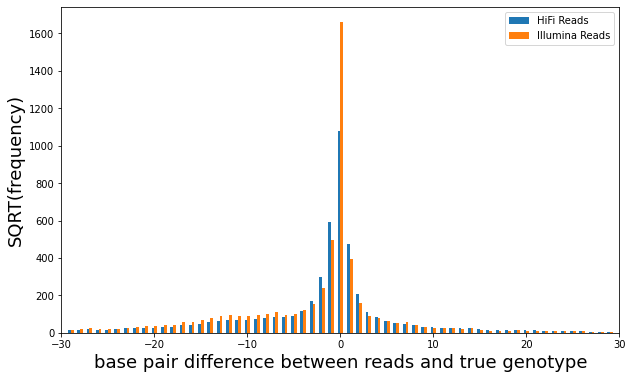

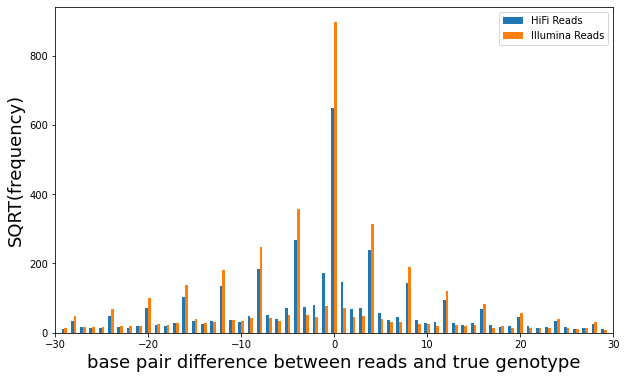

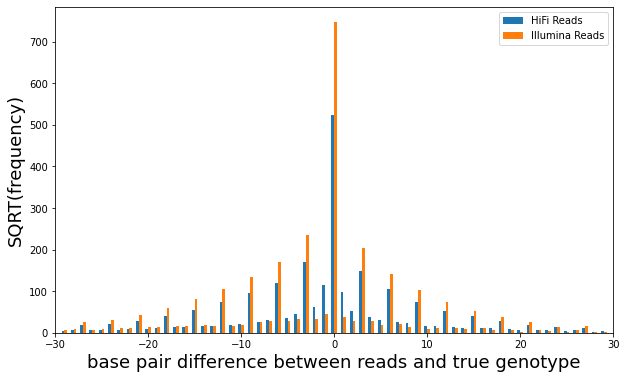

In [9]:
def plot_diff(df, limit, addr = None):
    ALLREADS_short = list(df['ALLREADS_short'])
    ALLREADS_long = list(df['ALLREADS_long'])
    diff_dict_long = defaultdict(int)
    diff_dict_short = defaultdict(int)
    for allread in ALLREADS_long:
        allread = allread.split(";")
        for diff in allread:
            diff = diff.split("|")
            if diff[0] == ".":
                  continue  
            if abs(int(diff[0])) < limit:
                diff_dict_long[int(diff[0])] += int(diff[1])
    for allread in ALLREADS_short:
        allread = allread.split(";")
        for diff in allread:
            diff = diff.split("|")
            if diff[0] == ".":
                  continue 
            if abs(int(diff[0])) < limit:
                diff_dict_short[int(diff[0])] += int(diff[1])
            
    plt.figure(figsize = (10,6))
    w = 0.3
    plt.bar([x - w/2 for x in list(diff_dict_long.keys())] , [np.sqrt(x) for x in list(diff_dict_long.values())], 
            label = 'HiFi Reads', width = 0.3)
    plt.bar([x + w/2 for x in list(diff_dict_short.keys())], [np.sqrt(x) for x in list(diff_dict_short.values())], 
            label = 'Illumina Reads', width = 0.3)
    plt.legend()
    plt.xlim([-limit, limit])
    plt.xlabel("base pair difference between reads and true genotype",fontsize=18)
    plt.ylabel("SQRT(frequency)",fontsize=18)
    if addr:
        plt.savefig(addr, dpi = 700)
    plt.show()
            
homopolymer_20_60 = both_with_calls[(both_with_calls['REF_long'].str.len() < 60) & 
                                 (both_with_calls['REF_long'].str.len() > 20) & (both_with_calls['PERIOD'] == 1)]  

tetra_40_100 = both_with_calls[(both_with_calls['REF_long'].str.len() < 100) & 
                                 (both_with_calls['REF_long'].str.len() > 40) & (both_with_calls['PERIOD'] == 4)]  

tri_30_100 = both_with_calls[(both_with_calls['REF_long'].str.len() < 100) & 
                                 (both_with_calls['REF_long'].str.len() > 30) & (both_with_calls['PERIOD'] == 3)]  
plot_diff(homopolymer_20_60, 30, "pdfs/homopolymer_20_60.pdf")
plot_diff(tetra_40_100, 30, "pdfs/tetra_40_100.pdf")
plot_diff(tri_30_100, 30, "pdfs/tri_30_100.pdf")



In [47]:
reference = pd.read_csv("metadata/GRCh38.hipstr_reference_pre.bed", sep = "\t", header=None)
reference['len'] = reference[2] - reference[1]
len(reference[reference['len'] > 100]) / len(reference) * 100

1.565214207920339

In [64]:
both_with_calls[(both_with_calls['concordance'] == 1) & (both_with_calls['alt_alleles'] == 0)]

,#CHROM,START_short,REF_short,PERIOD,END_short,ID,GT_short,ALLREADS_short,START_long,REF_long,...,ALLREADS_long,alt_alleles,inexact_alleles,LEN_long,LEN_short,HipSTR_long_mean,HipSTR_mean,diff_GT_long,concordance,concordance_1
0,chr1,16717.0,GGTGGTGGTGGGGGCGGTGGGGGTGGTG,3,16744.0,Human_STR_2,GGTGGTGGTGGGGGCGGTGGGGGTGGTG|GGTGGTGGTGGGGGCGG...,0|90;9|1,16717.0,GGTGGTGGTGGGGGCGGTGGGGGTGGTG,...,0|15;1|2,0.0,0.0,27.0,27.0,0.0,0.0,0.0,1,1
5,chr1,50571.0,TTTCCTTTCCTTTCCTTGCTCTTCTTTCTCTCCTATTGCTTTCCTT...,5,50626.0,Human_STR_17,TTTCCTTTCCTTTCCTTGCTCTTCTTTCTCTCCTATTGCTTTCCTT...,-2|1;0|45,50571.0,TTTCCTTTCCTTTCCTTGCTCTTCTTTCTCTCCTATTGCTTTCCTT...,...,-1|1;0|10,0.0,0.0,55.0,55.0,0.0,0.0,0.0,1,1
8,chr1,61351.0,AAAAAAAAAAA,1,61361.0,Human_STR_20,AAAAAAAAAAA|AAAAAAAAAAA,0|9,61351.0,AAAAAAAAAAA,...,-1|1;0|10,0.0,0.0,10.0,10.0,0.0,0.0,0.0,1,1
16,chr1,103256.0,AAAAGTAAAATAAAATAAAATAAAA,5,103280.0,Human_STR_39,AAAAGTAAAATAAAATAAAATAAAA|AAAAGTAAAATAAAATAAAA...,0|35,103256.0,AAAAGTAAAATAAAATAAAATAAAA,...,-1|2;0|18;1|2,0.0,0.0,24.0,24.0,0.0,0.0,0.0,1,1
18,chr1,105609.0,ATATATATATAGATATATA,2,105627.0,Human_STR_41,ATATATATATAGATATATA|ATATATATATAGATATATA,0|39,105609.0,ATATATATATAGATATATA,...,0|21;1|1;2|1,0.0,0.0,18.0,18.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604622,chrY,26665854.0,AGTGGAGCGGAGTGGAGTGGA,5,26665874.0,Human_STR_1618958,AGTGGAGCGGAGTGGAGTGGA,0|38,26665854.0,AGTGGAGCGGAGTGGAGTGGA,...,-65|3;-1|1;0|293;1|3,0.0,0.0,20.0,20.0,0.0,0.0,NaN,1,1
1604623,chrY,26665986.0,TGGAGTGGAGTGGCATGGAGTGGAGTGGAGTGGAATGGAGTGGAAT...,5,26666191.0,Human_STR_1618959,TGGAGTGGAGTGGCATGGAGTGGAGTGGAGTGGAATGGAGTGGAAT...,-5|2;0|8;5|1,26665986.0,TGGAGTGGAGTGGCATGGAGTGGAGTGGAGTGGAATGGAGTGGAAT...,...,-15|2;-10|17;-9|1;-7|1;-6|1;-5|28;-4|1;-3|1;-2...,0.0,0.0,205.0,205.0,0.0,0.0,NaN,1,1
1604624,chrY,26666359.0,TGGAGTGGAGTGGAATAGAGAGGAATGAATTGGAATGGAGTGTAGT...,5,26666553.0,Human_STR_1618960,TGGAGTGGAGTGGAATAGAGAGGAATGAATTGGAATGGAGTGTAGT...,-1|1;0|69,26666359.0,TGGAGTGGAGTGGAATAGAGAGGAATGAATTGGAATGGAGTGTAGT...,...,-21|1;-20|44;-2|1;-1|5;0|217;1|8;6|4;10|2;11|5...,0.0,0.0,194.0,194.0,0.0,0.0,NaN,1,1
1604642,chrY,26671001.0,GTGGAGTGGAGTGGAGTG,5,26671018.0,Human_STR_1618979,GTGGAGTGGAGTGGAGTG,-38|1;-6|1;-5|75;0|1011,26671001.0,GTGGAGTGGAGTGGAGTG,...,-5|3;-1|2;0|149;1|2,0.0,0.0,17.0,17.0,0.0,0.0,NaN,1,1


In [37]:
long_repeats = both[both['LEN_short'] > 250]
print(len(long_repeats))
print(len(long_repeats[long_repeats['ALLREADS_short'] == "."])/len(long_repeats))
print(len(long_repeats[((long_repeats['GB'] == "0|0") | 
                         (long_repeats['GB'] == "0") | (long_repeats['GB'] == "."))])/len(long_repeats))

5660
0.9869257950530035
0.9978798586572438


In [40]:
long_repeats[long_repeats['ALLREADS_short'] != "."].describe()

,START_short,PERIOD,END_short,START_long,END_long,alt_alleles,inexact_alleles,LEN_long,LEN_short
count,7.400000e+01,74.000000,7.400000e+01,7.400000e+01,7.400000e+01,74.000000,74.000000,74.000000,74.000000
mean,8.493588e+07,3.081081,8.493615e+07,8.493588e+07,8.493615e+07,1.621622,0.094595,264.013514,263.905405
std,5.083522e+07,1.119647,5.083521e+07,5.083522e+07,5.083521e+07,0.566235,0.294652,13.048375,12.825669
min,7.492100e+05,2.000000,7.494910e+05,7.492100e+05,7.494910e+05,0.000000,0.000000,247.000000,251.000000
25%,4.975970e+07,2.000000,4.975995e+07,4.975970e+07,4.975995e+07,1.000000,0.000000,255.000000,255.000000
50%,7.799899e+07,3.000000,7.799925e+07,7.799899e+07,7.799925e+07,2.000000,0.000000,261.000000,260.500000
75%,1.168912e+08,4.000000,1.168915e+08,1.168912e+08,1.168915e+08,2.000000,0.000000,270.000000,270.000000
max,2.047686e+08,6.000000,2.047688e+08,2.047686e+08,2.047688e+08,2.000000,1.000000,323.000000,323.000000
